Imports

In [76]:
#!pip install hurst

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc
from scipy import stats


from scipy.fft import fft, fftfreq
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # This stops it showing warnings about "smaller than value shown."

Generate Data - note added noise for the trend up and down lines as many things don't work with perfectly aligned data.

In [64]:
# 1. Stationary - all same value
stationary = np.array([4]+[5] * 98 + [6])

# 2. Trending up - simple +1 increments
trending_up = np.arange(100) + np.random.normal(0, 0.5, 100)

# 3. Trending down - simple -1 decrements
trending_down = trending_up_noisy[::-1]  # Flip it to a down trend.

# 4. Cycling - simple sine wave pattern
cycling = np.array([0, 1, 2, 1, 0, -1, -2, -1] * 13)[:100]  # Repeat pattern

# 5. Exponential up - exponential growth
exponential_up = np.array([2**i for i in range(100)]) + np.random.normal(0, 1e5, 100)

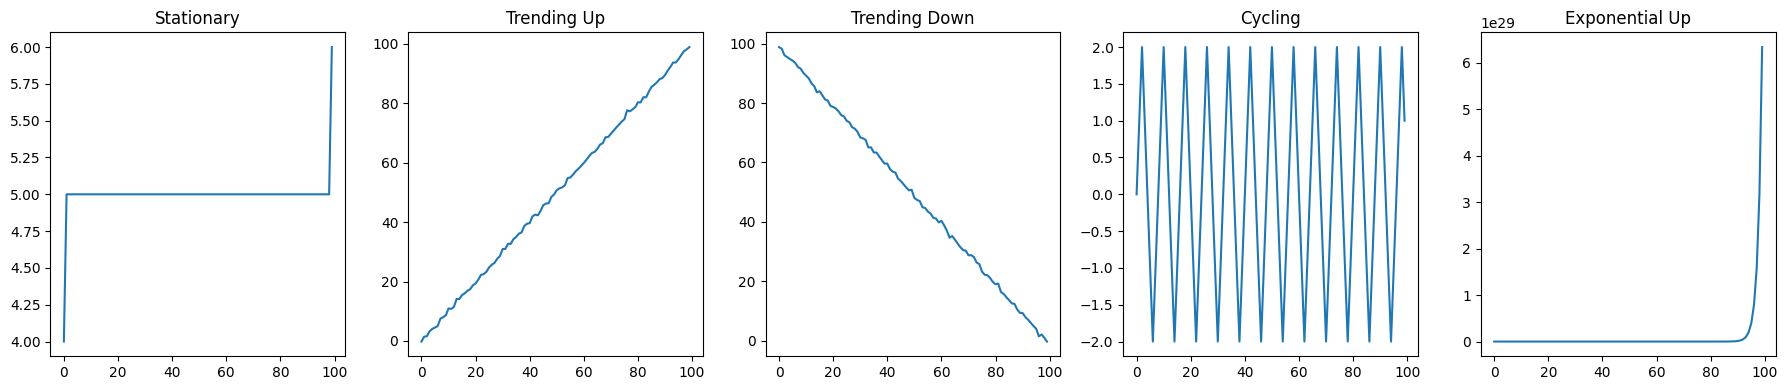

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(18, 4))  # 1 row, 5 columns

axes[0].plot(stationary)
axes[0].set_title("Stationary")

axes[1].plot(trending_up)
axes[1].set_title("Trending Up")

axes[2].plot(trending_down)
axes[2].set_title("Trending Down")

axes[3].plot(cycling)
axes[3].set_title("Cycling")

axes[4].plot(exponential_up)
axes[4].set_title("Exponential Up")

plt.tight_layout()
plt.show()

Augmented Dickey-Fuller Test

In [66]:
result1 = adfuller(stationary)
result2 = adfuller(trending_up)
result3 = adfuller(trending_down)
result4 = adfuller(cycling)
result5 = adfuller(exponential_up)
print(f"Stationary P-Value: {result1[1]}")  # P-value < 0.05 then reject default hypothesis = stationary
print(f"Trending Up P-Value: {result2[1]}")  # P-value > 0.05 then accept default hypothesis = non-stationary
print(f"Trending Down P-Value: {result3[1]}")  # P-value > 0.05 then accept default hypothesis = non-stationary
print(f"Cycling P-Value: {result4[1]}")  # P-value < 0.05 then reject default hypothesis = stationary (cycling around a flat line)
print(f"Exponential Up P-Value: {result5[1]}")  # P-value > 0.05 then accept default hypothesis = non-stationary

Stationary P-Value: 8.1165643065793e-17
Trending Up P-Value: 0.9623759906491101
Trending Down P-Value: 0.9760717072130382
Cycling P-Value: 0.0
Exponential Up P-Value: 1.0


Kwiatkowski-Phillips-Schmidt-Shin Test

In [67]:
# Regression='c' is like ADF test. Regression='ct' is trend stationary.
result1 = kpss(stationary, regression='ct')
result2 = kpss(trending_up, regression='ct')
result3 = kpss(trending_down, regression='ct')
result4 = kpss(cycling, regression='ct')
result5 = kpss(exponential_up, regression='ct')
print(f"Stationary P-Value: {result1[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Trending Up P-Value: {result2[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Trending Down P-Value: {result3[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Cycling P-Value: {result4[1]}")  # P-value > 0.05 then accept default hypothesis = trend-stationary (cycling around a flat line)
print(f"Exponential Up P-Value: {result5[1]}")  # P-value < 0.05 then reject default hypothesis = non-trend stationary

Stationary P-Value: 0.1
Trending Up P-Value: 0.1
Trending Down P-Value: 0.1
Cycling P-Value: 0.1
Exponential Up P-Value: 0.030749875769875982


Hurst Exponent

In [73]:
result1 = compute_Hc(stationary)
result2 = compute_Hc(trending_up_noisy)
result3 = compute_Hc(trending_down_noisy)
result4 = compute_Hc(cycling)
result5 = compute_Hc(exponential_up)

print(f"Stationary P-Value: {result1[0]}")  # H > 0.5 = linear trend [but is close to 0.5, so closer to a random walk]
print(f"Trending Up P-Value: {result2[0]}")  # H > 0.5 = linear trend
print(f"Trending Down P-Value: {result3[0]}")  # H > 0.5 = linear trend
print(f"Cycling P-Value: {result4[0]}")  # H < 0.5 = mean reversion (cycling)
print(f"Exponential Up P-Value: {result5[0]}")  # H > 0.5 = linear trend [but is close to 0.5, so closer to a random walk]

# Horizontal trends or exponential trends will appear as a random walk because the function isn't really equipped to handle it.



Stationary P-Value: 0.6418893895475476
Trending Up P-Value: 1.0019041403855224
Trending Down P-Value: 1.0321847935751285
Cycling P-Value: 0.020364999245466597
Exponential Up P-Value: 0.5289118539073698


In [ ]:
# ============================================================================
# 5. FOURIER ANALYSIS / FOURIER TRANSFORM
# ============================================================================

def fourier_analysis(data, sampling_rate=1.0, plot=False):
    """
    Performs Fourier analysis on time series data

    Parameters:
    - data: Time series data
    - sampling_rate: Sampling rate of the data
    - plot: Whether to plot the results

    Returns:
    - Dictionary with frequency domain analysis
    """
    data = np.array(data)
    n = len(data)

    # Compute FFT
    fft_values = fft(data)
    frequencies = fftfreq(n, d=1/sampling_rate)

    # Calculate magnitude and phase
    magnitude = np.abs(fft_values)
    phase = np.angle(fft_values)
    power_spectral_density = magnitude**2

    # Consider only positive frequencies
    positive_freq_mask = frequencies >= 0
    freq_positive = frequencies[positive_freq_mask]
    magnitude_positive = magnitude[positive_freq_mask]
    psd_positive = power_spectral_density[positive_freq_mask]

    # Find dominant frequencies
    dominant_freq_idx = np.argsort(psd_positive[1:])[-5:] + 1  # Top 5, excluding DC
    dominant_frequencies = freq_positive[dominant_freq_idx]
    dominant_powers = psd_positive[dominant_freq_idx]

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Time domain
        ax1.plot(data)
        ax1.set_title('Time Domain Signal')
        ax1.set_xlabel('Sample')
        ax1.set_ylabel('Amplitude')

        # Frequency domain
        ax2.plot(freq_positive, psd_positive)
        ax2.set_title('Power Spectral Density')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Power')
        ax2.set_yscale('log')

        plt.tight_layout()
        plt.show()

    return {
        'frequencies': freq_positive,
        'magnitude': magnitude_positive,
        'power_spectral_density': psd_positive,
        'dominant_frequencies': dominant_frequencies,
        'dominant_powers': dominant_powers,
        'total_power': np.sum(psd_positive)
    }

# ============================================================================
# 6. TRANSFER ENTROPY
# ============================================================================

def transfer_entropy(x, y, k=1, tau=1):
    """
    Calculates Transfer Entropy from X to Y

    Parameters:
    - x, y: Time series data
    - k: Embedding dimension
    - tau: Time delay

    Returns:
    - Transfer entropy value
    """
    def _embed(data, dimension, delay):
        """Create time-delay embedding"""
        n = len(data)
        m = n - (dimension - 1) * delay
        embedded = np.zeros((m, dimension))
        for i in range(dimension):
            embedded[:, i] = data[i * delay:m + i * delay]
        return embedded

    def _mutual_info(X, Y, bins=10):
        """Calculate mutual information"""
        # Discretize the data
        x_discrete = np.digitize(X, np.histogram_bin_edges(X, bins=bins))
        y_discrete = np.digitize(Y, np.histogram_bin_edges(Y, bins=bins))

        # Calculate joint and marginal probabilities
        xy_hist = np.histogram2d(x_discrete, y_discrete, bins=bins)[0]
        xy_prob = xy_hist / np.sum(xy_hist)
        x_prob = np.sum(xy_prob, axis=1, keepdims=True)
        y_prob = np.sum(xy_prob, axis=0, keepdims=True)

        # Calculate mutual information
        mi = 0
        for i in range(bins):
            for j in range(bins):
                if xy_prob[i, j] > 0 and x_prob[i, 0] > 0 and y_prob[0, j] > 0:
                    mi += xy_prob[i, j] * np.log2(xy_prob[i, j] / (x_prob[i, 0] * y_prob[0, j]))

        return mi

    # Ensure arrays are the same length
    min_len = min(len(x), len(y))
    x = np.array(x[:min_len])
    y = np.array(y[:min_len])

    # Create embeddings
    max_delay = (k - 1) * tau + 1
    if len(x) <= max_delay:
        return {'transfer_entropy': np.nan, 'interpretation': 'Insufficient data for embedding'}

    # Y embedded vectors
    y_embedded = _embed(y[:-1], k, tau)  # Y^k_n
    y_future = y[max_delay:]  # Y_{n+1}

    # X embedded vectors
    x_embedded = _embed(x[:-1], k, tau)  # X^k_n

    # Align arrays
    min_embedded_len = min(len(y_embedded), len(x_embedded), len(y_future))
    y_embedded = y_embedded[:min_embedded_len]
    x_embedded = x_embedded[:min_embedded_len]
    y_future = y_future[:min_embedded_len]

    if min_embedded_len < 10:
        return {'transfer_entropy': np.nan, 'interpretation': 'Insufficient data'}

    # Calculate transfer entropy using mutual information
    # TE = I(Y_{n+1}; X^k_n | Y^k_n)
    # This is approximated as I(Y_{n+1}, X^k_n, Y^k_n) - I(Y_{n+1}, Y^k_n)

    # For simplicity, we'll use a basic approximation
    # Combine X and Y embeddings
    xy_combined = np.concatenate([x_embedded, y_embedded], axis=1)

    # Calculate mutual informations
    try:
        mi_y_future_xy = _mutual_info(y_future, xy_combined.flatten())
        mi_y_future_y = _mutual_info(y_future, y_embedded.flatten())

        te = mi_y_future_xy - mi_y_future_y
    except:
        te = np.nan

    interpretation = f"Transfer entropy from X to Y: {te:.4f}" if not np.isnan(te) else "Could not calculate"

    return {
        'transfer_entropy': te,
        'interpretation': interpretation,
        'embedding_dimension': k,
        'time_delay': tau
    }

# ============================================================================
# 7. PRINCIPAL COMPONENT ANALYSIS (PCA)
# ============================================================================

def perform_pca(data, n_components=None, standardize=True):
    """
    Performs Principal Component Analysis

    Parameters:
    - data: Input data (samples x features)
    - n_components: Number of components to keep (None for all)
    - standardize: Whether to standardize the data

    Returns:
    - Dictionary with PCA results
    """
    data = np.array(data)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # Standardize data if requested
    if standardize:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = data
        scaler = None

    # Perform PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    return {
        'transformed_data': transformed_data,
        'components': pca.components_,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance_ratio': cumulative_variance,
        'singular_values': pca.singular_values_,
        'mean': pca.mean_,
        'n_components': pca.n_components_,
        'scaler': scaler,
        'pca_object': pca
    }

# ============================================================================
# EXAMPLE USAGE AND DEMONSTRATION
# ============================================================================

def demonstrate_all_tests():
    """
    Demonstrates all the statistical tests with sample data
    """
    print("=" * 60)
    print("STATISTICAL TESTS AND ANALYSIS DEMONSTRATION")
    print("=" * 60)

    # Generate sample data
    np.random.seed(42)
    n = 100

    # Time series data
    time_series = np.cumsum(np.random.randn(n))  # Random walk
    stationary_series = np.random.randn(n)  # White noise
    trending_series = np.arange(n) + np.random.randn(n) * 0.5  # Trending

    # Multivariate data for PCA
    multivariate_data = np.random.multivariate_normal([0, 0, 0], [[1, 0.5, 0.3], [0.5, 1, 0.2], [0.3, 0.2, 1]], n)

    print("\n1. AUGMENTED DICKEY-FULLER TEST")
    print("-" * 40)
    adf_result = augmented_dickey_fuller_test(time_series)
    print(f"Test Statistic: {adf_result['test_statistic']:.4f}")
    print(f"P-value: {adf_result['p_value']:.4f}")
    print(f"Interpretation: {adf_result['interpretation']}")

    print("\n2. KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST")
    print("-" * 40)
    kpss_result = kpss_test(time_series)
    print(f"Test Statistic: {kpss_result['test_statistic']:.4f}")
    print(f"P-value: {kpss_result['p_value']:.4f}")
    print(f"Interpretation: {kpss_result['interpretation']}")

    print("\n3. HURST EXPONENT")
    print("-" * 40)
    hurst_result = hurst_exponent(time_series)
    print(f"Hurst Exponent: {hurst_result['hurst_exponent']:.4f}")
    print(f"Interpretation: {hurst_result['interpretation']}")

    print("\n4. MANN-KENDALL TREND TEST")
    print("-" * 40)
    mk_result = mann_kendall_test(trending_series)
    print(f"S Statistic: {mk_result['S_statistic']}")
    print(f"Z Statistic: {mk_result['Z_statistic']:.4f}")
    print(f"P-value: {mk_result['p_value']:.4f}")
    print(f"Trend: {mk_result['trend']}")

    print("\n5. FOURIER ANALYSIS")
    print("-" * 40)
    # Create a signal with known frequencies
    t = np.linspace(0, 1, n, False)
    signal = np.sin(2*np.pi*5*t) + 0.5*np.sin(2*np.pi*10*t) + np.random.randn(n)*0.1
    fourier_result = fourier_analysis(signal, sampling_rate=n)
    print(f"Top 3 dominant frequencies: {fourier_result['dominant_frequencies'][-3:]}")
    print(f"Total power: {fourier_result['total_power']:.2f}")

    print("\n6. TRANSFER ENTROPY")
    print("-" * 40)
    # Create coupled time series
    x_coupled = np.random.randn(50)
    y_coupled = np.zeros(50)
    for i in range(1, 50):
        y_coupled[i] = 0.5 * y_coupled[i-1] + 0.3 * x_coupled[i-1] + np.random.randn() * 0.1

    te_result = transfer_entropy(x_coupled, y_coupled)
    print(f"Transfer Entropy: {te_result['transfer_entropy']:.4f}")
    print(f"Interpretation: {te_result['interpretation']}")

    print("\n7. PRINCIPAL COMPONENT ANALYSIS")
    print("-" * 40)
    pca_result = perform_pca(multivariate_data)
    print(f"Explained variance ratios: {pca_result['explained_variance_ratio']}")
    print(f"Cumulative variance (first 2 components): {pca_result['cumulative_variance_ratio'][:2]}")
    print(f"Shape of transformed data: {pca_result['transformed_data'].shape}")

    print("\n" + "=" * 60)
    print("DEMONSTRATION COMPLETE")
    print("=" * 60)

if __name__ == "__main__":
    demonstrate_all_tests()

10
